# Load libraries

Import the required libraries.

In [1]:
import tensorflow as tf
print(tf.__version__)

# List all available physical devices
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"TensorFlow is using the following GPU(s): {gpus}")
else:
    print("No GPU detected by TensorFlow.")

print("TensorFlow version:", tf.__version__)
print("Is GPU available?", tf.test.is_gpu_available())


KeyboardInterrupt: 

2.18.0
No GPU detected by TensorFlow.
TensorFlow version: 2.18.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available? False


In [12]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

# Run a simple operation
a = tf.random.normal([10000, 10000])
b = tf.random.normal([10000, 10000])
c = tf.matmul(a, b)


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0


In [2]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
import numpy as np

from tqdm import tqdm
from typing import Callable, Tuple

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

from tensorflow.keras import backend as K
from tensorflow.python.keras.utils.losses_utils import reduce_weighted_loss

# Prepare data

Run the following three cells to define the required library functions for loading the data.

The first cell defines the name of the variables in the input files and the corrresponding data statistics. The statistics can be used for preprocessing the data. 

In [1]:
"""Constants for the data reader."""

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics 
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

The following cell defines cropping functions for extracting regions of the desired size from the input data.

In [2]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Randomly axis-align crop input and output image tensors.

    Args:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
        sample_size: side length (square) to crop to.
        num_in_channels: number of channels in input_img.
        num_out_channels: number of channels in output_img.
    Returns:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
    """
    combined = tf.concat([input_img, output_img], axis=2)
    combined = tf.image.random_crop(
        combined,
        [sample_size, sample_size, num_in_channels + num_out_channels])
    input_img = combined[:, :, 0:num_in_channels]
    output_img = combined[:, :, -num_out_channels:]
    return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Center crops input and output image tensors.

    Args:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
        sample_size: side length (square) to crop to.
    Returns:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
    """
    central_fraction = sample_size / input_img.shape[0]
    input_img = tf.image.central_crop(input_img, central_fraction)
    output_img = tf.image.central_crop(output_img, central_fraction)
    return input_img, output_img

NameError: name 'tf' is not defined

The following cell provides code for parsing the contents of the TensorFlow Record files. In addition to loading the data, it also offers functions for various preprocessing operations, such as clipping, rescaling, or normalizing the data.  

In [4]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
    """Extracts the base key from the provided key.

    Earth Engine exports TFRecords containing each data variable with its
    corresponding variable name. In the case of time sequences, the name of the
    data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
    where 'variable' is the name of the variable, and n the number of elements
    in the time sequence. Extracting the base key ensures that each step of the
    time sequence goes through the same normalization steps.
    The base key obeys the following naming pattern: '([a-zA-Z]+)'
    For instance, for an input key 'variable_1', this function returns 'variable'.
    For an input key 'variable', this function simply returns 'variable'.

    Args:
        key: Input key.

    Returns:
        The corresponding base key.

    Raises:
        ValueError when `key` does not match the expected pattern.
    """
    match = re.match(r'([a-zA-Z]+)', key)
    if match:
        return match.group(1)
    
    raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and rescales inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and rescale.
        key: Key describing the inputs.

    Returns:
        Clipped and rescaled input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, _, _ = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and normalizes inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and normalize.
        key: Key describing the inputs.

    Returns:
        Clipped and normalized input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, mean, std = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    inputs = inputs - mean
    return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
    """Creates a features dictionary for TensorFlow IO.

    Args:
        sample_size: Size of the input tiles (square).
        features: List of feature names.

    Returns:
        A features dictionary for TensorFlow IO.
    """
    sample_shape = [sample_size, sample_size]
    features = set(features)
    columns = [
        tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
        for _ in features
    ]
    return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Reads a serialized example.

    Args:
        example_proto: A TensorFlow example protobuf.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        num_in_channels: Number of input channels.
        clip_and_normalize: True if the data should be clipped and normalized.
        clip_and_rescale: True if the data should be clipped and rescaled.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data should be cropped in the center.

    Returns:
        (input_img, output_img) tuple of inputs and outputs to the ML model.
    """
    if (random_crop and center_crop):
        raise ValueError('Cannot have both random_crop and center_crop be True')
    input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
    feature_names = input_features + output_features
    features_dict = _get_features_dict(data_size, feature_names)
    features = tf.io.parse_single_example(example_proto, features_dict)

    if clip_and_normalize:
        inputs_list = [
            _clip_and_normalize(features.get(key), key) for key in input_features
        ]
    elif clip_and_rescale:
        inputs_list = [
            _clip_and_rescale(features.get(key), key) for key in input_features
        ]
    else:
        inputs_list = [features.get(key) for key in input_features]
  
    inputs_stacked = tf.stack(inputs_list, axis=0)
    input_img = tf.transpose(inputs_stacked, [1, 2, 0])

    outputs_list = [features.get(key) for key in output_features]
    assert outputs_list, 'outputs_list should not be empty'
    outputs_stacked = tf.stack(outputs_list, axis=0)

    outputs_stacked_shape = outputs_stacked.get_shape().as_list()
    assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
    output_img = tf.transpose(outputs_stacked, [1, 2, 0])

    if random_crop:
        input_img, output_img = random_crop_input_and_output_images(
            input_img, output_img, sample_size, num_in_channels, 1)
    if center_crop:
        input_img, output_img = center_crop_input_and_output_images(
            input_img, output_img, sample_size)
    return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
    """Gets the dataset from the file pattern.

    Args:
        file_pattern: Input file pattern.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        batch_size: Batch size.
        num_in_channels: Number of input channels.
        compression_type: Type of compression used for the input files.
        clip_and_normalize: True if the data should be clipped and normalized, False
          otherwise.
        clip_and_rescale: True if the data should be clipped and rescaled, False
          otherwise.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data shoulde be cropped in the center.

    Returns:
        A TensorFlow dataset loaded from the input file pattern, with features
        described in the constants, and with the shapes determined from the input
        parameters to this function.
    """
    if (clip_and_normalize and clip_and_rescale):
        raise ValueError('Cannot have both normalize and rescale.')
    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.interleave(
        lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(
        lambda x: _parse_fn(  # pylint: disable=g-long-lambda
            x, data_size, sample_size, num_in_channels, clip_and_normalize,
            clip_and_rescale, random_crop, center_crop),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

Let's load training, validation and test sets using function we define above

In [5]:
BATCH_SIZE = 32

train_dataset = get_dataset('/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_train*', 
    data_size=64, sample_size=32, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

validation_dataset = get_dataset('/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_eval*', 
    data_size=64, sample_size=32, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

test_dataset = get_dataset('/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_test*',
    data_size=64, sample_size=32, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

# Visualize data
We will check content of the dataset by plotting them

Let's plot the data!

First we define the names for each of our variables.

In [6]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

Define some helper variables for the plot. 

In [7]:
def plot_samples_from_dataset(dataset: tf.data.Dataset, n_rows: int):
    """
    Plot 'n_rows' rows of samples from dataset.
    
    Args:
        dataset (Dataset): Dataset from which to plot samples.
        n_rows (int): Number of rows to plot.
    """
    global TITLES
    
    # Get batch
    inputs, labels = None, None
    for elem in dataset:
        inputs, labels = elem
        break
    
    fig = plt.figure(figsize=(15,6.5))

    # Variables for controllong the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    # Number of data variables
    n_features = 12
    for i in range(n_rows):
        for j in range(n_features + 1):
            plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
            if i == 0:
                plt.title(TITLES[j], fontsize=13)
            if j < n_features - 1:
                plt.imshow(inputs[i, :, :, j], cmap='viridis')
            if j == n_features - 1:
                plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
            if j == n_features:
                plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM) 
            plt.axis('off')
    plt.tight_layout()
    

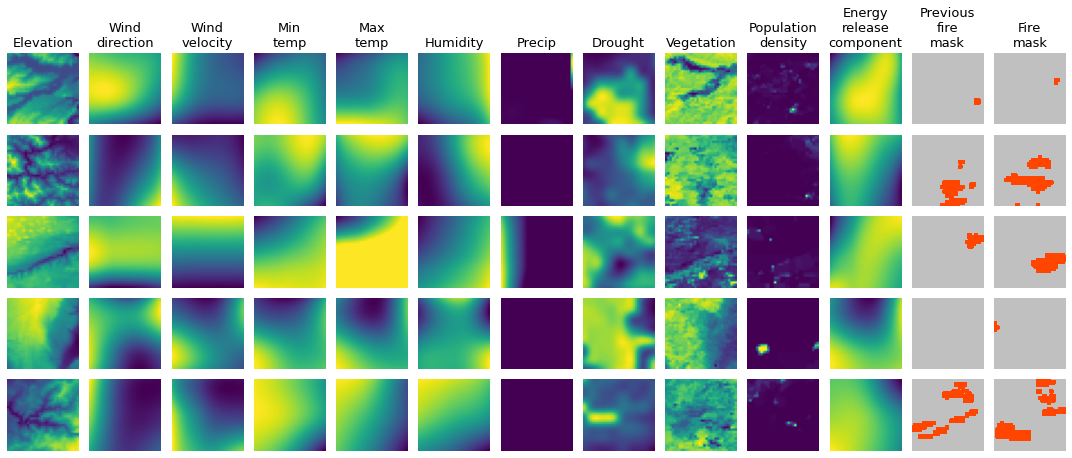

In [8]:
plot_samples_from_dataset(train_dataset, 5)

# Building testing

## Metrics
Let's define metric calculation functions

In [11]:
def IoU_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculation of intersection over union metric.
    
    Args:
        real_mask (Tensor): Ground-truth mask
        predicted_mask (Tensor): Mask predicted by model
    Returns:
        (float): IoU metric value
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)
    
    intersection = np.logical_and(real_mask, predicted_mask)
    union = np.logical_or(real_mask, predicted_mask)
    
    if np.sum(union) == 0:
        return 1
    return np.sum(intersection) / np.sum(union)

def recall_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculation of recall metric.
    
    Args:
        real_mask (Tensor): Ground-truth mask
        predicted_mask (Tensor): Mask predicted by model
    Returns:
        (float): recall metric value
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)
    
    true_positives = np.sum(np.logical_and(real_mask, predicted_mask))
    actual_positives = np.sum(real_mask)
    if actual_positives == 0:
        return 1
    
    return true_positives / actual_positives

def precision_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculation of precision metric.
    
    Args:
        real_mask (Tensor): Ground-truth mask
        predicted_mask (Tensor): Mask predicted by model
    Returns:
        (float): precision metric value
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)
    
    true_positives = np.sum(np.logical_and(real_mask, predicted_mask))
    predicted_positives = np.sum(predicted_mask)
    if predicted_positives == 0:
        return 1
    
    return true_positives / predicted_positives

## Loss functions

In [12]:
def dice_coef(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """
    Dice loss function calculator.
    
    Args:
        y_true (Tensor): 
        y_pred (Tensor):
    Returns:
        (Tensor): Dice loss for each element of a batch.
    """
    smooth = 1e-6
    y_true_f = K.reshape(y_true, (BATCH_SIZE, -1))
    y_pred_f = K.reshape(y_pred, (BATCH_SIZE, -1))
    intersection = K.sum(y_true_f * y_pred_f, axis=1)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f, axis=1) + K.sum(y_pred_f, axis=1) + smooth)

def weighted_bincrossentropy(true: tf.Tensor, pred: tf.Tensor, weight_zero: float = 0.01, weight_one: float = 1) -> float:
    """
    Calculates weighted binary cross entropy. The weights are fixed.
        
    This can be useful for unbalanced catagories.
    
    Adjust the weights here depending on what is required.
    
    For example if there are 10x as many positive classes as negative classes,
        if you adjust weight_zero = 1.0, weight_one = 0.1, then false positives 
        will be penalize 10 times as much as false negatives.
    
    Args:
        true (Tensor): Ground-truth values
        pred (Tensor): Predited values
        weight_zero (float): Weight of class 0 (no-fire)
        weight_one (float): Weight of class 1 (fire)
        
    """
  
    # calculate the binary cross entropy
    bin_crossentropy = K.binary_crossentropy(true, pred)
    
    # apply the weights
    weights = true * weight_one + (1. - true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy 
    
    return K.mean(weighted_bin_crossentropy, axis=1)

def bce_dice_loss(y_true: tf.Tensor, y_pred: tf.Tensor):
    """
    BCE loss function calculator.
    
    Args:
        y_true (Tensor): 
        y_pred (Tensor):
    Returns:
        (Tensor): Mean BCE Dice loss over a batch.
    """
    
    y_true_f = K.reshape(y_true, (BATCH_SIZE, -1))
    y_pred_f = K.reshape(y_pred, (BATCH_SIZE, -1))
    return reduce_weighted_loss(weighted_bincrossentropy(y_true_f, y_pred_f) + dice_coef(y_true, y_pred))

## Evaluation loop
Let's define evaluation process over specified dataset

In [13]:
def evaluate_model(prediction_function: Callable[[tf.Tensor], tf.Tensor],
                   eval_dataset: tf.data.Dataset) -> Tuple[float, float, float, float]:
    """
    Loads dataset according to file pattern and evaluates model's predictions on it.
    
    Parameters:
        model (Callable[[tf.Tensor], tf.Tensor]): Function for model inference.
        eval_dataset (tf.dataDataset): Dataset for evaluation.
    
    Returns:
        Tuple[float, float, float, float]: IoU score, recall score, precision score and mean loss.
    """
    IoU_measures = []
    recall_measures = []
    precision_measures = []
    losses = []
    
    for inputs, labels in tqdm(eval_dataset):
        # Prediction shape (N, W, H)
        predictions = prediction_function(inputs)
        for i in range(inputs.shape[0]):
            IoU_measures.append(IoU_metric(labels[i, :, :,  0], predictions[i, :, :]))
            recall_measures.append(recall_metric(labels[i, :, :,  0], predictions[i, :, :]))
            precision_measures.append(precision_metric(labels[i, :, :,  0], predictions[i, :, :]))
        labels_cleared = tf.where(labels < 0, 0, labels)
        losses.append(bce_dice_loss(labels_cleared, tf.expand_dims(tf.cast(predictions, tf.float32), axis=-1)))
            
    mean_IoU = np.mean(IoU_measures)
    mean_recall = np.mean(recall_measures)
    mean_precision = np.mean(precision_measures)
    mean_loss = np.mean(losses)
    return mean_IoU, mean_recall, mean_precision, mean_loss

# Modeling technique
Description of technique

## Torch Model

In [14]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-pif64l_8
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-pif64l_8
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301602 sha256=5628b342178fdcbacf8624caba13c95dd2a2d91457e020fa6a303a90d060bc54
  Stored in directory: /tmp/pip-ephem-wheel-cache-hb0lj4ny/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Successfully built tensorflow-examples


In [2]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[32, 32, 12], include_top=False, weights=None)
base_model.summary()

NameError: name 'tf' is not defined

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

def build_CNN_AE_model() -> Model:
    """
    Create CNN auto encode model.
    
    Returns:
        (Model): Keras model.
    """
    # input shape of 32x32 pixels, 12 channels. 
    # include_top=false means do not include the FC layers at the end of the network. weights = none means random initialization
    base_model = tf.keras.applications.MobileNetV2(input_shape=[32, 32, 12], 
                                                    include_top=False, weights=None)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 16x16
        'block_3_expand_relu',   # 8x8
        'block_6_expand_relu',   # 4x4
        'block_13_expand_relu',  # 2x2
        'block_16_project',      # 1x1
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = True

    up_stack = [
        pix2pix.upsample(512, 3),  # (1,1, 1280) -> (2, 2, 512)
        pix2pix.upsample(256, 3),  # (2, 2, 512) -> (4, 4, 256) 
        pix2pix.upsample(128, 3),  # (4, 4, 256) -> (8, 8, 128) 
        pix2pix.upsample(64, 3),   # (8, 8, 128) -> (16, 16, 64)
    ]

    inputs = tf.keras.layers.Input(shape=[32, 32, 12])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model. (16, 16, 64) -> (32, 32, 1)
    last = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=2,
    padding='same')  

    x = last(x)
    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)
    
# Create the segmentation model
segmentation_model = build_CNN_AE_model()
segmentation_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 12)] 0                                            
__________________________________________________________________________________________________
model_4 (Functional)            [(None, 16, 16, 96), 1844576     input_9[0][0]                    
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 2, 2, 512)    1476608     model_4[0][4]                    
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 2, 2, 1088)   0           sequential_12[0][0]              
                                                                 model_4[0][3]              

## TF Training loop

In [ ]:
def train_model(model: Model, train_dataset: c, epochs:int=10) -> Tuple[List[float], List[float]]:
    """
    Trains a model using train dataset. (Save weights of model with best IoU)
    
    Args:
        model (Model): Model to train.
        train_dataset (Dataset): Training dataset.
        epochs (int): Number of epochs
    Returns:
        Tuple[List[float], List[float]]: Train losses and Validation losses
    """
    loss_fn = bce_dice_loss
    optimizer = tf.keras.optimizers.Adam()
    batch_losses = []
    val_losses = []
    best_IoU = 0.0
    
    for epoch in range(epochs):
        losses = []
        print(f'Epoch {epoch+1}/{epochs}')
        # Iterate through the dataset
        progress = tqdm(train_dataset)
        for images, masks in progress:
            with tf.GradientTape() as tape:
                # Forward pass
                predictions = model(images, training=True)
                label = tf.where(masks < 0, 0, masks)
                # Compute the loss
                loss = loss_fn(label, predictions)
                losses.append(loss.numpy())
                progress.set_postfix({'batch_loss': loss.numpy()})
            # Compute gradients
            gradients = tape.gradient(loss, model.trainable_variables)
            # Update the model's weights
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # Evaluate model
        print("Evaluation...")
        IoU, recall, precision, val_loss = evaluate_model(lambda x: tf.where(model.predict(x) > 0.5, 1, 0)[:,:,:,0], validation_dataset)
        print("Validation set metrics:")
        print(f"Mean IoU: {IoU}\nMean precision: {precision}\nMean recall: {recall}\nValidation loss: {val_loss}\n")
        # Save best model
        if IoU > best_IoU:
            best_IoU = IoU
            model.save_weights("best.h5")
        
        # Print the loss for monitoring
        print(f'Epoch: {epoch}, Train loss: {np.mean(losses)}')
        batch_losses.append(np.mean(losses))
        val_losses.append(val_loss)
    
    print(f"Best model IoU: {best_IoU}")
    return batch_losses, val_losses

# Set reproducability
tf.random.set_seed(1337)

segmentation_model = build_CNN_AE_model()
train_losses, val_losses = train_model(segmentation_model, train_dataset, epochs=15)

Epoch 1/15


469it [01:21,  5.75it/s, batch_loss=0.907]


Evaluation...


59it [00:09,  6.52it/s]


Validation set metrics:
Mean IoU: 0.14331379861481086
Mean precision: 1.0
Mean recall: 0.14331379861481086
Validation loss: 1.3011871576309204

Epoch: 0, Train loss: 0.8957541584968567
Epoch 2/15


469it [01:11,  6.60it/s, batch_loss=0.954]


Evaluation...


59it [00:06,  9.09it/s]


Validation set metrics:
Mean IoU: 0.14384656366542356
Mean precision: 1.0
Mean recall: 0.14384656366542356
Validation loss: 1.3141230344772339

Epoch: 1, Train loss: 0.853360652923584
Epoch 3/15


469it [01:11,  6.61it/s, batch_loss=1]    


Evaluation...


59it [00:06,  8.76it/s]


Validation set metrics:
Mean IoU: 0.144589812351395
Mean precision: 0.98823477179897
Mean recall: 0.14460692568238767
Validation loss: 1.305704116821289

Epoch: 2, Train loss: 0.8475750684738159
Epoch 4/15


469it [01:14,  6.32it/s, batch_loss=0.948]


Evaluation...


59it [00:07,  8.40it/s]


Validation set metrics:
Mean IoU: 0.1433089841740223
Mean precision: 0.8945633393422419
Mean recall: 0.14403901382400666
Validation loss: 1.306636095046997

Epoch: 3, Train loss: 0.8446628451347351
Epoch 5/15


469it [01:14,  6.33it/s, batch_loss=1.25] 


Evaluation...


59it [00:06,  8.86it/s]


Validation set metrics:
Mean IoU: 0.20555815566927113
Mean precision: 0.6421822209179227
Mean recall: 0.27815343138792664
Validation loss: 1.1260842084884644

Epoch: 4, Train loss: 0.8415102958679199
Epoch 6/15


469it [01:12,  6.44it/s, batch_loss=0.896]


Evaluation...


59it [00:06,  9.15it/s]


Validation set metrics:
Mean IoU: 0.21179901378617777
Mean precision: 0.5772294007313346
Mean recall: 0.3311235286764777
Validation loss: 1.0965074300765991

Epoch: 5, Train loss: 0.8373739123344421
Epoch 7/15


469it [01:15,  6.24it/s, batch_loss=0.912]


Evaluation...


59it [00:06,  8.70it/s]


Validation set metrics:
Mean IoU: 0.22718389868173255
Mean precision: 0.514520784753798
Mean recall: 0.4587731176693771
Validation loss: 0.997051477432251

Epoch: 6, Train loss: 0.8376500010490417
Epoch 8/15


469it [01:12,  6.45it/s, batch_loss=1.23] 


Evaluation...


59it [00:06,  8.88it/s]


Validation set metrics:
Mean IoU: 0.21109727512129914
Mean precision: 0.3974850590803057
Mean recall: 0.5146407229890371
Validation loss: 0.9681373238563538

Epoch: 7, Train loss: 0.838692307472229
Epoch 9/15


469it [01:13,  6.36it/s, batch_loss=0.995]


Evaluation...


59it [00:06,  8.79it/s]


Validation set metrics:
Mean IoU: 0.16878471738134254
Mean precision: 0.2472130073975511
Mean recall: 0.5363825756003731
Validation loss: 1.0156428813934326

Epoch: 8, Train loss: 0.8377482891082764
Epoch 10/15


469it [01:12,  6.43it/s, batch_loss=1.17] 


Evaluation...


59it [00:06,  8.81it/s]


Validation set metrics:
Mean IoU: 0.19113236631692787
Mean precision: 0.3216388614088288
Mean recall: 0.5163002923028327
Validation loss: 1.0130091905593872

Epoch: 9, Train loss: 0.8334581851959229
Epoch 11/15


469it [01:13,  6.40it/s, batch_loss=0.947]


Evaluation...


59it [00:06,  8.71it/s]


Validation set metrics:
Mean IoU: 0.12924316054423113
Mean precision: 0.16185736121202648
Mean recall: 0.5841170920130478
Validation loss: 1.0485676527023315

Epoch: 10, Train loss: 0.8389037847518921
Epoch 12/15


469it [01:12,  6.43it/s, batch_loss=0.91] 


Evaluation...


59it [00:06,  8.94it/s]


Validation set metrics:
Mean IoU: 0.12700048408513073
Mean precision: 0.15403776087700718
Mean recall: 0.6863884514240917
Validation loss: 0.991820216178894

Epoch: 11, Train loss: 0.8327350616455078
Epoch 13/15


469it [01:13,  6.35it/s, batch_loss=0.982]


Evaluation...


59it [00:06,  8.85it/s]


Validation set metrics:
Mean IoU: 0.1339343895225055
Mean precision: 0.16967160470150502
Mean recall: 0.660611851944621
Validation loss: 1.0518213510513306

Epoch: 12, Train loss: 0.8296789526939392
Epoch 14/15


469it [01:14,  6.32it/s, batch_loss=0.955]


Evaluation...


59it [00:06,  9.01it/s]


Validation set metrics:
Mean IoU: 0.1338325165322745
Mean precision: 0.17747150414722815
Mean recall: 0.6012509814040354
Validation loss: 1.056018590927124

Epoch: 13, Train loss: 0.8299720883369446
Epoch 15/15


469it [01:12,  6.44it/s, batch_loss=0.986]


Evaluation...


59it [00:06,  8.89it/s]

Validation set metrics:
Mean IoU: 0.1365309524739177
Mean precision: 0.1882452564189088
Mean recall: 0.5816883139829014
Validation loss: 1.0524158477783203

Epoch: 14, Train loss: 0.8320257663726807
Best model IoU: 0.22718389868173255


## Plot loss functions

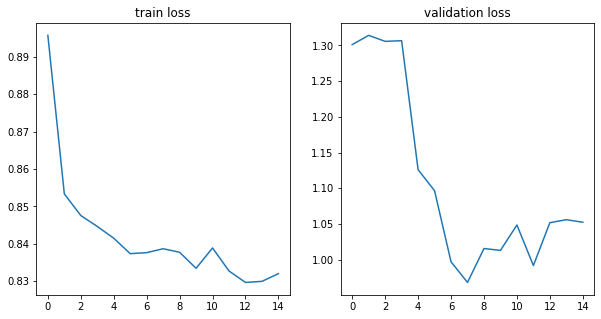

In [23]:
def plot_train_and_val_losses(train_losses, val_losses):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(train_losses)
    axs[0].set_title("train loss")
    
    axs[1].plot(val_losses)
    axs[1].set_title("validation loss")
    
    plt.show()


plot_train_and_val_losses(train_losses, val_losses)

# Testing

In [24]:
# Load best model
segmentation_model = build_CNN_AE_model()
segmentation_model.load_weights("best.h5")

## Metrics on test set
Calculating metrics on test set

In [25]:
print("Evaluation...")
print("Test set metrics:")
IoU, recall, precision, val_loss = evaluate_model(lambda x: tf.where(segmentation_model.predict(x) > 0.5, 1, 0)[:,:,:,0], test_dataset)
print(f"Mean IoU: {IoU}\nMean precision: {precision}\nMean recall: {recall}\nTest loss: {val_loss}")

Evaluation...
Test set metrics:


53it [00:07,  6.82it/s]

Mean IoU: 0.2577864919377781
Mean precision: 0.5249494666917128
Mean recall: 0.5018194532704091
Test loss: 0.8867089152336121


## Comparison with statistical model
How better is our model in comparison of prediction of only high frequency fire cells (>0.2 probability of being on fire)

In [26]:
class NaivePredictor:
    """
    Naive predictor that predicts fire only if cell has chance being on fire more than 0.2
    """
    def __init__(self) -> None:
        """
        Initialize model and create frequency matrix
        """
        self.frequency_matrix = tf.zeros((32, 32), dtype=np.float32)
    
    def train(self, train_dataset: tf.data.Dataset) -> None:
        """
        Train by calculating frequency for each cell.
        
        Args:
            train_dataset (Dataset): Dataset to train on.
        """
        for _, labels in tqdm(train_dataset):
            label_batch = labels[:, :, :, 0]
            label_batch = tf.where(label_batch < 0, 0, label_batch)
            self.frequency_matrix = self.frequency_matrix + np.sum(label_batch, axis=0)
        self.frequency_matrix = self.frequency_matrix / np.max(self.frequency_matrix)
        self.frequency_matrix = tf.where(self.frequency_matrix > 0.2, 1, 0)
    
    def predict(self, X: tf.Tensor) -> tf.Tensor:
        """
        Dummy predict function.
        
        Args:
            train_dataset (Dataset): Dataset to train on.
        Returns:
            (Tensor): Predicted fire mask.
        """
        return tf.tile(tf.expand_dims(self.frequency_matrix, axis=0), [X.shape[0],1,1])

naive_predictor = NaivePredictor()
naive_predictor.train(train_dataset)

469it [00:03, 128.53it/s]


In [27]:
IoU, recall, precision, val_loss = evaluate_model(naive_predictor.predict, test_dataset)
print(f"Mean IoU: {IoU}\nMean precision: {precision}\nMean recall: {recall}\nTest loss: {val_loss}")

53it [00:03, 14.56it/s]

Mean IoU: 0.02646374518946122
Mean precision: 0.02646374518946122
Mean recall: 1.0
Test loss: 1.1003408432006836


Compare trained model with Naive one: <br/>
1. <font color="green">IoU 23% better</font>
2. <font color="green">Precision 47% better</font>
3. <font color="red">Recall 50% worse</font>

# Inference on test set

In [28]:
def show_inference(n_rows: int, features: tf.Tensor, label: tf.Tensor, prediction_function: Callable[[tf.Tensor], tf.Tensor]) -> None:
    """
    Show model inference through images.
    
    Args:
        n_rows (int): Number of rows for subplots.
        features (tf.Tensor): Input features.
        label (tf.Tensor): True labels.
        prediction_function (Callable[[tf.Tensor], tf.Tensor]): Function for model prediction.
    """
    
    # Variables for controllong the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    
    fig = plt.figure(figsize=(15,n_rows*4))
    
    prediction = prediction_function(features)
    for i in range(n_rows):
        plt.subplot(n_rows, 3, i*3 + 1)
        plt.title("Previous day fire")
        plt.imshow(features[i, :, :, -1], cmap=CMAP, norm=NORM)
        plt.axis('off')
        plt.subplot(n_rows, 3, i*3 + 2)
        plt.title("True next day fire")
        plt.imshow(label[i, :, :, 0], cmap=CMAP, norm=NORM)
        plt.axis('off')
        plt.subplot(n_rows, 3, i*3 + 3)
        plt.title("Predicted next day fire")
        plt.imshow(prediction[i, :, :])
        plt.axis('off')    
    plt.tight_layout()

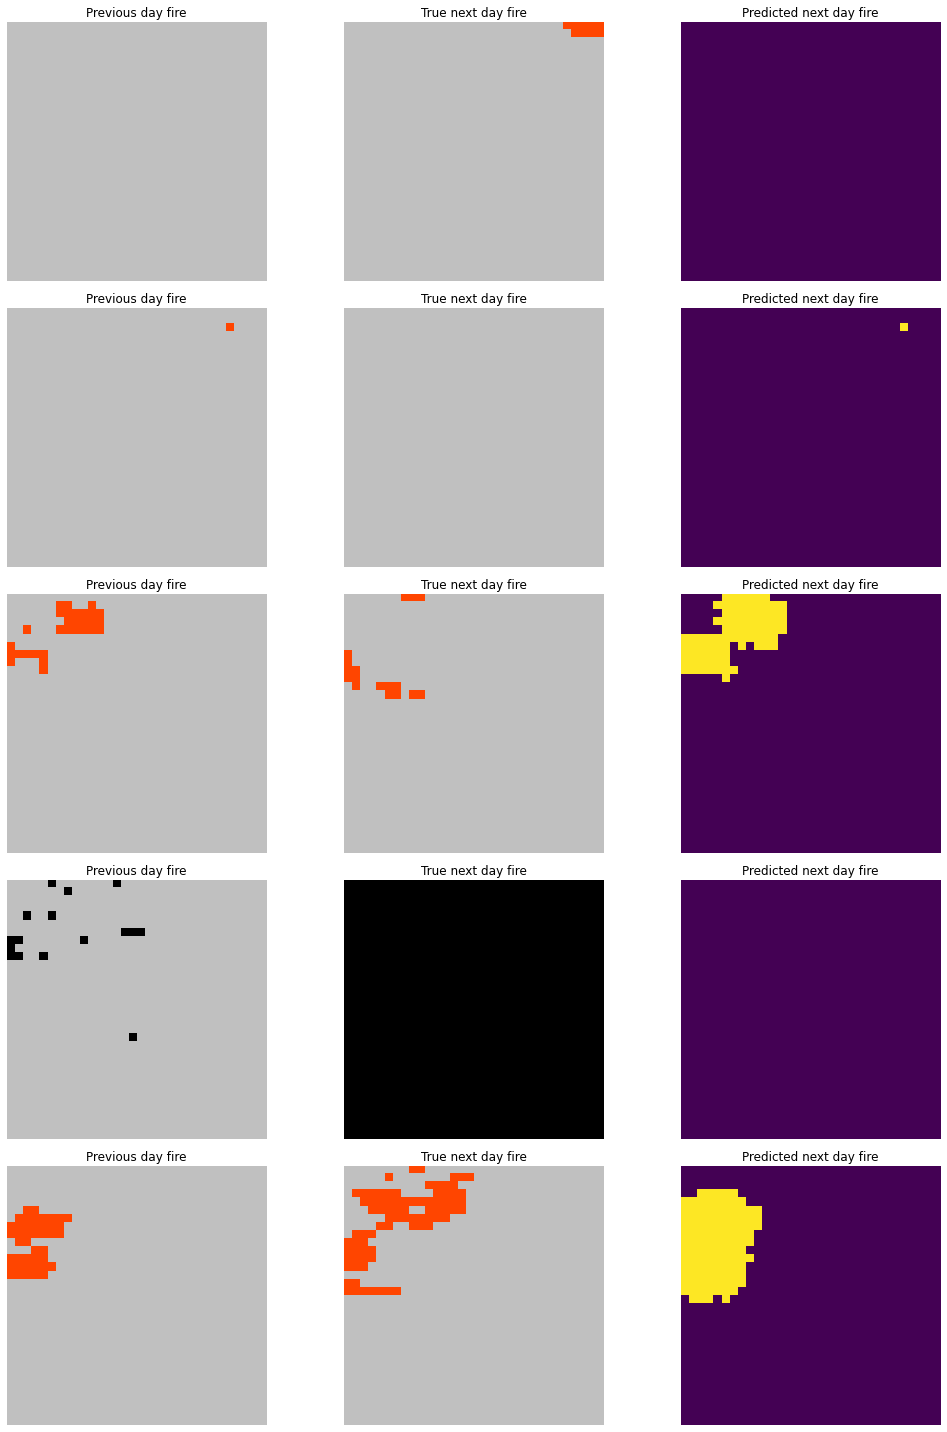

In [34]:
features, labels = next(iter(test_dataset))
show_inference(5, features, labels, lambda x: tf.where(segmentation_model.predict(x) > 0.5, 1, 0)[:,:,:,0])